In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import os
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler    
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pycuda.driver as cuda
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder

In [1108]:
train = pd.read_csv('../dados/train_token_acentuado_V009.csv',index_col=0, sep=';')


In [1110]:
grupos_split = pd.read_csv('../dados/catwithSplit.csv',index_col=0)

In [1112]:
from sklearn.preprocessing import LabelEncoder
cats_encoder = LabelEncoder()
train['CATEGORIA_encoded'] = cats_encoder.fit_transform(train['CATEGORIA'])

In [201]:
def processingLabel(dadosBase, labelname):
    linha=0
    dados = dadosBase.copy()
    dados['CATEGORIA_EDIT'] = dados[labelname].str.replace('/',' ')
    dados['CATEGORIA_EDIT'] = dados['CATEGORIA_EDIT'].str.replace(' E ',' ')
    dados['CATEGORIA_EDIT'] = dados['CATEGORIA_EDIT'].str.replace(' PARA ',' ')
    dados['CATEGORIA_EDIT'] = dados['CATEGORIA_EDIT'].str.replace(' DE ',' ')
    dados['CATEGORIA_EDIT'] = dados['CATEGORIA_EDIT'].str.replace(' EM ',' ')
    dados['CATEGORIA_EDIT'] = dados['CATEGORIA_EDIT'].str.replace('  ',' ')
    dados['CATEGORIA_EDIT'] = dados['CATEGORIA_EDIT'].str.replace(' A ',' ')
    dados['CATEGORIA_EDIT'] = dados['CATEGORIA_EDIT'].str.replace(' O ',' ')
    dados['CATEGORIA_EDIT'] = dados['CATEGORIA_EDIT'].str.replace(' DO ',' ')
    dados['CATEGORIA_EDIT'] = dados['CATEGORIA_EDIT'].str.replace('CREME GEL DENTAL ','GEL ')

    for categoria_ok in dados['CATEGORIA_EDIT']:
        linha+=1
        
        words = categoria_ok.split()
        tamanho = len(words)
        #wordseq = []
        for seqword in range(tamanho):
            
            #wordseq.append(words[seqword])
            nameColumn = 'CATEGORIA_EDIT'+'w'+str(seqword)
            #print(coluna, categoria_ok, nameColumn, words[seqword])
            #dados[(dados[coluna]==categoria_ok),nameColumn] = words[seqword]
            #dados = dados.copy()
            dados.loc[(dados['CATEGORIA_EDIT']==categoria_ok),nameColumn] = words[seqword]

        #print(dados.columns)
        #if linha > 10:
            #return dados
    return dados



In [15]:
def splitWordsCol(dados, coluna):
    #linha = 0
    for categoria_ok in dados[coluna]:
        #linha+=1
        
        words = categoria_ok.split()
        tamanho = len(words)
        #wordseq = []
        for seqword in range(tamanho):
            words[seqword]
            #wordseq.append(words[seqword])
            nameColumn = coluna+'w'+str(seqword)
            #print(coluna, categoria_ok, nameColumn, words[seqword])
            #dados[(dados[coluna]==categoria_ok),nameColumn] = words[seqword]
            dados.loc[(dados[coluna]==categoria_ok),nameColumn] = words[seqword]
        
        #if linha >10:
            #return

In [17]:
#train['CATEGORIA_OUT_ACCENT'] = train["CATEGORIA"].apply(lambda x: unidecode(x))

In [21]:
#train['CATEGORIA_OUT_ACCENT'] = train['CATEGORIA_OUT_ACCENT'].str.lower()

In [203]:
train_split = processingLabel(train, 'CATEGORIA')

In [197]:
splitWordsCol(train, 'CATEGORIA')

In [12]:
from sklearn.preprocessing import LabelEncoder
cats_encoder = LabelEncoder()
train['CATEGORIA_EDITw0_encode'] = cats_encoder.fit_transform(train['CATEGORIA_EDITw0'])

In [1117]:
y = train['CATEGORIA_encoded'].copy()
X = train
X_train0, X_val0, y_train1, y_val1 = train_test_split(X, y , train_size=0.9,stratify=y, random_state=0)#suffle

X_train1=X_train0.drop(["DESCRIÇÃO PARCEIRO",'DESCRIÇÃO PARCEIROajuste','SUB-CATEGORIA', 
                   'CATEGORIA', 'DEPARTAMENTO', 'CATEGORIA_encoded'
                ], axis=1).copy()
X_val=X_val0.drop(["DESCRIÇÃO PARCEIRO",'DESCRIÇÃO PARCEIROajuste','SUB-CATEGORIA', 
                   'CATEGORIA', 'DEPARTAMENTO', 'CATEGORIA_encoded'
                ], axis=1).copy()

y_train=y_train1.copy()
y_val=y_val1.copy()

X_train, y_train = np.array(X_train1), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
print(f'X_train {X_train.shape} y_train {y_train.shape} X_val {X_val.shape} y_val {y_val.shape}' )

X_train (19808, 1024) y_train (19808,) X_val (2201, 1024) y_val (2201,)


In [1120]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

#torch.set_printoptions(precision=10)
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

In [1125]:
class_count = np.unique(y_train, return_counts=True)[1:2]
class_weights = 1./torch.tensor(class_count[0].tolist(), dtype=torch.float) 

In [1126]:
"""
class_count = np.unique(y_train, return_counts=True)[1:2]
class_weights = 1./torch.tensor(class_count[0].tolist(), dtype=torch.float) 
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]
class_weights_all = class_weights[target_list]

para fazer o balanceamento a técnica usada foi:
Como são 332 categorias mais o número de exemplos para cada categoria é diferente. Verificou-se quantos exemplos se tem para 
cada categoria e para cada item da lista de exemplos atribuiu o seu percentual em relação a sua quantidade de amostras.
Exemplo:
Suponha que o primeiro exemplo seja a categoria: CAFE. E temos no total 8 registros com a categoria CAFE. Então o valor para essa linha
será 1/8. 
Passando essa lista de pesos para a classe WeightedRandomSampler ela irá criar o 

weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
"""

'\nclass_count = np.unique(y_train, return_counts=True)[1:2]\nclass_weights = 1./torch.tensor(class_count[0].tolist(), dtype=torch.float) \ntarget_list = []\nfor _, t in train_dataset:\n    target_list.append(t)\n    \ntarget_list = torch.tensor(target_list)\ntarget_list = target_list[torch.randperm(len(target_list))]\nclass_weights_all = class_weights[target_list]\n\npara fazer o balanceamento a técnica usada foi:\nComo são 332 categorias mais o número de exemplos para cada categoria é diferente. Verificou-se quantos exemplos se tem para \ncada categoria e para cada item da lista de exemplos atribuiu o seu percentual em relação a sua quantidade de amostras.\nExemplo:\nSuponha que o primeiro exemplo seja a categoria: CAFE. E temos no total 8 registros com a categoria CAFE. Então o valor para essa linha\nserá 1/8. \nPassando essa lista de pesos para a classe WeightedRandomSampler ela irá criar o \n\nweighted_sampler = WeightedRandomSampler(\n    weights=class_weights_all,\n    num_sampl

In [1231]:
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          #sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=BATCH_SIZE,
                          #sampler=weighted_sampler
)

In [1232]:
#train_dataset.X_data.shape
train_loader.dataset.X_data.shape

torch.Size([19808, 1024])

In [1233]:
"""SIMULACAO DE UMA REDE NEURAL
dados = X_train_batch.cpu()
model1 = nn.Linear(1024, 1024)
model2 = nn.BatchNorm1d(1024)
modelRelu = nn.ReLU()
modelDropout = nn.Dropout(p=0.1)
modelLSTM = nn.LSTM(input_size=1024, hidden_size=1024, num_layers=2)

out1 = model1(dados)
out2 = model2(out1)
out3 = modelRelu(out2)
out4 = modelDropout(out3)
out4 = out4.view(-1,32,1024)
out5, (ht, ct) = modelLSTM(out4)
"""

'SIMULACAO DE UMA REDE NEURAL\ndados = X_train_batch.cpu()\nmodel1 = nn.Linear(1024, 1024)\nmodel2 = nn.BatchNorm1d(1024)\nmodelRelu = nn.ReLU()\nmodelDropout = nn.Dropout(p=0.1)\nmodelLSTM = nn.LSTM(input_size=1024, hidden_size=1024, num_layers=2)\n\nout1 = model1(dados)\nout2 = model2(out1)\nout3 = modelRelu(out2)\nout4 = modelDropout(out3)\nout4 = out4.view(-1,32,1024)\nout5, (ht, ct) = modelLSTM(out4)\n'

In [1234]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        # definição dos layers, tem estado. Quardam o estado que eles aprendem durante o treinamento.
        self.layer_1 = nn.Linear(num_feature, num_feature)
        self.layer_2 = nn.Linear(num_feature, num_feature)
        self.layer_3 = nn.Linear(num_feature, num_feature)
        #self.layer_3 = nn.LSTM(input_size=num_feature, hidden_size=1024, num_layers=2)#, batch_first=True
        self.layer_out = nn.Linear(num_feature, num_class) 
        
        #self.relu = nn.ReLU()
        #self.PReLU = nn.PReLU()
        self.LeakyReLU = nn.LeakyReLU()
        #self.sigmoid = nn.Sigmoid()
        #self.dropout = nn.AlphaDropout(p=0.05) #zera alguns termos para evitar co-adaptacao
        self.batchnorm1 = nn.BatchNorm1d(num_feature, momentum=0.08)  #melhorou TRASTICAMENTE QUANDO COLOQUEI ESSA LAYER
        self.batchnorm2 = nn.BatchNorm1d(num_feature, momentum=0.08)
        self.batchnorm3 = nn.BatchNorm1d(num_feature, momentum=0.08)
        #self.gru = nn.GRU(num_feature, num_feature)
        #self.conv1 = nn.Conv1d(num_feature, num_feature, kernel_size=2)
        
        self.num_feature = num_feature
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.LeakyReLU(x)
        #x = self.sigmoid(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x) #quando aumentei esse layer não aumentou a performance
        #x = self.LeakyReLU(x)
        #x = F.relu(x)
        #x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x) #quando aumentei esse layer não aumentou a performance
        #x = self.LeakyReLU(x)
        
        #x = self.layer_3(x)
        #print(x.shape[0], self.num_feature)
        #x = x.view(-1,x.shape[0],self.num_feature)
        #x, (ht, ct) = self.layer_3(x)   # LSTM não mudou o resultado
        #print(x.shape, x.shape[0], self.num_feature)
        #x = x.view(x.shape[1],self.num_feature)
        #x = self.batchnorm3(x)
        #x = F.relu(x)
        #x = self.dropout(x)
        #x, hidden = self.gru(x, self.num_feature)
        #x = self.conv1
        #x = torch.tanh(x) não alterou o resultado
        x = self.layer_out(x)
        
        return x

In [1235]:
EPOCHS = 25
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X_train[0])
NUM_CLASSES = y.value_counts().count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(60) # sempre gerar os mesmos parametros
torch.manual_seed(60) # sempre gerar os mesmos parametros
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)
print(model)
weightSequencial = torch.from_numpy(np.arange(0, 53, 1)).long() #class_weights
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

accuracy_stats = {
    'train': []
    ,"val": []
}

loss_stats = {
    'train': []
    ,"val": []
}

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

#list(model.parameters()) 

MulticlassClassification(
  (layer_1): Linear(in_features=1024, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer_3): Linear(in_features=1024, out_features=1024, bias=True)
  (layer_out): Linear(in_features=1024, out_features=332, bias=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.01)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.08, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.08, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(1024, eps=1e-05, momentum=0.08, affine=True, track_running_stats=True)
)


In [1236]:
listPredicao = []
listReal = []
for e in tqdm((range(1, EPOCHS+1))):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
        # VALIDATION    
    with torch.no_grad():

        val_epoch_loss = 0
        val_epoch_acc = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
            y_pred_softmax = torch.log_softmax(y_val_pred, dim = 1)
            _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
            listPredicao.append(y_pred_tags.cpu().numpy())
            listReal.append(X_val_batch.cpu().numpy())
            target = y_pred_tags.cpu().numpy()
            f1_batch = f1_score(y_val_batch.cpu().numpy(),target,average='micro')
            
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
        
    
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    print(f'Epoch {e+0:03}:|Train Loss:{train_epoch_loss/len(train_loader):.3f}\
    |Train Acc:{train_epoch_acc/len(train_loader):.3f}|\
    |Val Loss:{val_epoch_loss/len(val_loader):.3f}|\
    |val Acc:{val_epoch_acc/len(val_loader):.3f}|f1: {f1_batch:.2f}')
    
    

Epoch 001:|Train Loss:4.050    |Train Acc:0.000|    |Val Loss:3.086|    |val Acc:0.000|f1: 0.36
Epoch 002:|Train Loss:2.338    |Train Acc:10.000|    |Val Loss:2.321|    |val Acc:22.857|f1: 0.40
Epoch 003:|Train Loss:1.647    |Train Acc:50.000|    |Val Loss:2.141|    |val Acc:22.857|f1: 0.52
Epoch 004:|Train Loss:1.237    |Train Acc:84.516|    |Val Loss:1.960|    |val Acc:48.571|f1: 0.44
Epoch 005:|Train Loss:0.979    |Train Acc:96.129|    |Val Loss:2.002|    |val Acc:68.571|f1: 0.56
Epoch 006:|Train Loss:0.826    |Train Acc:99.677|    |Val Loss:1.864|    |val Acc:85.714|f1: 0.64
Epoch 007:|Train Loss:0.733    |Train Acc:100.000|    |Val Loss:1.941|    |val Acc:74.286|f1: 0.48
Epoch 008:|Train Loss:0.714    |Train Acc:99.677|    |Val Loss:1.955|    |val Acc:80.000|f1: 0.72
Epoch 009:|Train Loss:0.610    |Train Acc:100.000|    |Val Loss:1.914|    |val Acc:88.571|f1: 0.56
Epoch 010:|Train Loss:0.541    |Train Acc:100.000|    |Val Loss:1.886|    |val Acc:94.286|f1: 0.72
Epoch 011:|Train Lo

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

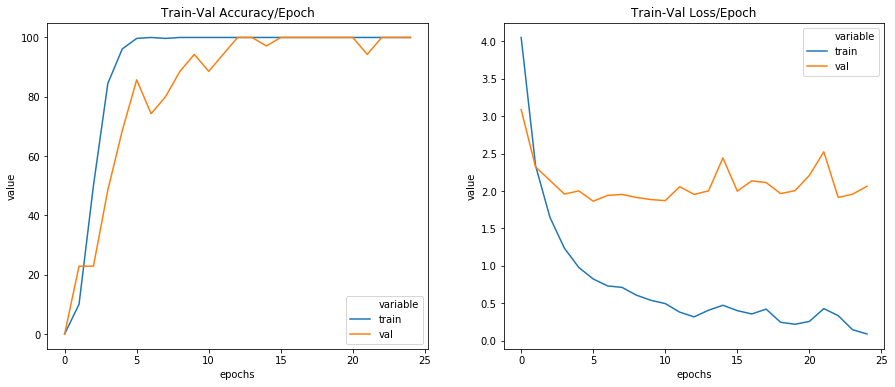

In [1237]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
fig.set_figheight(6)
fig.set_figwidth(15)
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [1189]:
y_pred_list = []
#esse no_grad é para o modelo saber que não está sendo treinado.
with torch.no_grad():
    model.eval()
    for X_batch, _ in tqdm(val_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        #if len(y_pred_list) == 3:
            #break

y_pred_list2 = [a.squeeze().tolist() for a in y_pred_list]

In [1239]:
listPredicao = np.hstack(y_pred_list)
listReal = val_loader.dataset.y_data.cpu().numpy()

In [1240]:
# = np.array([[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]])
#len(np.hstack(listReal))
listPredicao

array([ 80,   9, 228, ..., 223, 162, 102], dtype=int64)

In [1241]:
f1_score(listReal, listPredicao, average='micro')

0.6524307133121309

In [1198]:
print(y_val_batch)
print(y_pred_tags.cpu().numpy())
#y_val_batch[0]

tensor([103], device='cuda:0')
[102]


In [1199]:
f1_score(listReal, listPredicao, average='micro')

0.6524307133121309

In [1200]:
from scipy.stats import rankdata
xrank = y_pred_softmax.cpu().numpy()
rank = rankdata(xrank)
np.where(rank == 51)

(array([330], dtype=int64),)

# ANALISES RESULTADO

In [ ]:
print(classification_report(y_test, y_pred_list))

In [ ]:
testpred = X_test1.copy()
testpred['y_test'] = y_test
testpred['y_pred_list'] = y_pred_list
testpred['DEPARTAMENTO_pred'] = testpred['y_pred_list'].map(testpred.groupby(['encoded_DEPARTAMENTO'])['DEPARTAMENTO'].max())
pd.set_option('display.min_rows', 30)
testpred[(testpred['y_test']==18) & (testpred['y_test']==testpred['y_pred_list'])][['DESCRIÇÃO PARCEIROajuste','DEPARTAMENTO', 'DEPARTAMENTO_pred','y_test', 'y_pred_list']]

In [ ]:
testpred = X_test1.copy()
testpred['y_test'] = y_test
testpred['y_pred_list'] = y_pred_list
testpred['CATEGORIA_pred'] = testpred['y_pred_list'].map(testpred.groupby(['encoded_CATEGORIA'])['CATEGORIA'].max())
pd.set_option('display.min_rows', 30)
testpred[(testpred['y_test']==23) & (testpred['y_test']!=testpred['y_pred_list'])][['DESCRIÇÃO PARCEIROajuste','CATEGORIA', 'CATEGORIA_pred','y_test', 'y_pred_list']]

In [ ]:
classificacao = classification_report(y_test, y_pred_list, target_names=X_test1.groupby(['encoded_CATEGORIA'])['CATEGORIA'].max().values,
                      output_dict=True)
#classif1 = pd.DataFrame(classificacao).transpose()
#classif = classif1.copy()
#classif['sequencia'] = np.arange(len(classif))
#classif['categoria'] = classif.index
#pd.set_option('display.min_rows', 100)
#classif.index = classif['sequencia'].copy()
#classif = classif[:332]
#classif['quantidade'] = classif['sequencia'].map(train.groupby(['encoded_CATEGORIA'])['CATEGORIA'].count())
#classif.sort_values(by=['f1-score','quantidade'], ascending=[True, False]).head(50)

In [ ]:
#X_train1.groupby(['encoded_CATEGORIA'])['CATEGORIA'].max()
y_test

In [ ]:
classificacao = classification_report(y_test, y_pred_list, target_names=train.groupby(['encoded_CATEGORIA'])['CATEGORIA'].max().values,
                      output_dict=True)
classif1 = pd.DataFrame(classificacao).transpose()
classif = classif1.copy()
classif['sequencia'] = np.arange(len(classif))
classif['categoria'] = classif.index
pd.set_option('display.min_rows', 100)
classif.index = classif['sequencia'].copy()
classif = classif[:332]
classif['quantidade'] = classif['sequencia'].map(train.groupby(['encoded_CATEGORIA'])['CATEGORIA'].count())
classif.sort_values(by=['f1-score','quantidade'], ascending=[True, False]).head(50)

In [ ]:
classif[classif['categoria'].isin(['SUCO CONCENTRADO','SUCO CONCENTRADO'])]

In [ ]:
testpred[testpred['CATEGORIA'].isin(['SUCO CONCENTRADO','SUCO CONCENTRADO'])] \
[['CATEGORIA','DESCRIÇÃO PARCEIRO','DESCRIÇÃO PARCEIROajuste','CATEGORIA_pred']]#.groupby('CATEGORIA_pred').count()

In [ ]:
testpred[['DESCRIÇÃO PARCEIRO','DESCRIÇÃO PARCEIROajuste', 'CATEGORIA', 'SUB-CATEGORIA', 'DEPARTAMENTO', 'encoded_CATEGORIA'
         ,'encoded_DEPARTAMENTO','y_test', 'y_pred_list', 'CATEGORIA_pred']].to_csv('pred_categoria.csv')

# GERACAO DE DADOS TESTE

In [1201]:
test = pd.read_csv('../dados/test_token_acentuado_V008.csv', sep=';', index_col='Unnamed: 0')

In [1202]:
X_test = test.drop(["DESCRIÇÃO PARCEIRO", "DESCRIÇÃO PARCEIROajuste"], axis=1).copy()

In [1203]:
X_test = np.array(X_test)

In [1204]:
X_torch_test = torch.from_numpy(X_test).float().to(device)

In [1205]:
test

,DESCRIÇÃO PARCEIRO,DESCRIÇÃO PARCEIROajuste,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,SAL ROSA HIMALAIA C/ ALHO 500G,sal rosa himalaia com alho 500 g,-0.109958,0.998103,0.028219,-0.242036,0.003596,0.999369,0.303896,-0.545720,...,0.998616,-0.266062,-0.156677,0.048528,-0.056863,-0.067484,0.210461,-0.169423,0.848751,0.196053
1,JG BOLA NATAL ACASA C/17 DR/PR/BC R952,jg bola natal acasa com 17 dr pr bc r952,-0.114307,0.830608,-0.125117,-0.229309,0.007348,0.988526,0.143482,-0.074809,...,0.974836,-0.079083,-0.192524,0.239946,-0.059614,0.153593,0.127956,0.065728,0.995346,0.033947
2,MIST PREP LIQ CHA VDE LINEA 56ML-CX LIMAO,mist prep liq chá vde linea 56 ml cx limão,-0.166053,0.577840,-0.009664,-0.337555,-0.114559,0.908952,0.226533,-0.330732,...,0.887049,-0.237417,-0.197426,0.093031,0.008240,0.026127,0.099709,-0.066635,0.973878,-0.042607
3,ALICATE CUT+ESPAT MUNDIAL SANDY AMARELO,alicate cut+espat mundial sandy amarelo,-0.209057,0.918744,0.124509,-0.109616,-0.090302,0.982641,0.025554,-0.124358,...,0.961321,-0.136388,-0.216274,0.112482,-0.084384,0.012397,0.105544,-0.063482,0.982488,0.146783
4,MEIA PIZZA PEPPERONI UN,meia pizza pepperoni un,0.043281,0.683602,0.281087,-0.111475,0.020142,0.900551,0.197696,-0.103625,...,0.620174,-0.178057,-0.122943,-0.175522,0.009438,-0.107382,0.086998,-0.067600,0.941877,-0.200256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9428,BISC IMP ITAL GRISBI DOCE CAPPUCCINO CX 150G,bisc imp ital grisbi doce cappuccino cx 150 g,-0.107991,0.738020,0.189859,-0.244779,-0.011105,0.946660,0.193986,-0.255176,...,0.858993,-0.143784,-0.172469,0.011845,-0.093492,-0.077848,0.108661,0.019618,0.996490,-0.157552
9429,VINHO ARGENTINO SANTA ANA BCO SECO 700ML,vinho argentino santa anã bco seco 700 ml,-0.130344,0.888286,-0.062037,-0.362933,-0.280779,0.986076,0.119062,-0.317508,...,0.950832,-0.325040,0.034894,0.082375,0.079320,-0.102742,0.314141,-0.207004,0.995361,0.042614
9430,ALGODAO BOLA ISABABY 50G .,algodão bola isababy 50 g .,-0.167817,0.985210,0.194763,-0.158380,0.044229,0.984611,0.057403,-0.321860,...,0.978513,-0.287708,-0.082691,0.024421,-0.016037,-0.107523,-0.002109,-0.134209,0.965448,-0.057543
9431,ORG PIA OU DISC OP590TQ,org pia ou disc op590tq,-0.042605,0.823935,-0.238704,-0.139127,-0.148025,0.985489,-0.041849,-0.036834,...,0.956144,-0.169924,-0.076820,0.218980,-0.158949,0.142114,0.143164,-0.031371,0.969659,0.232359


In [1206]:
#from sklearn.preprocessing import LabelEncoder
#cats_encoder = LabelEncoder()
#grupos_split['CATEGORIA_encode'] = cats_encoder.fit_transform(grupos_split['CATEGORIA'])
def getCategoria(nro_categoria):   
    listaCategorias = cats_encoder.classes_.tolist()
    return listaCategorias[nro_categoria]
    

In [1211]:
getCategoria(0)
#grupos_split
#testEnvio

'ABSORVENTE'

In [1208]:
"""
test_predict_list = []
with torch.no_grad():
    model.eval()
    test_predict = model(X_torch)
    test_predict_softmax = torch.log_softmax(test_predict, dim = 1)
    _test, test_predict_tags = torch.max(test_predict_softmax, dim = 1)
    test_predict_list.append(test_predict_tags.cpu().numpy())
    """

'\ntest_predict_list = []\nwith torch.no_grad():\n    model.eval()\n    test_predict = model(X_torch)\n    test_predict_softmax = torch.log_softmax(test_predict, dim = 1)\n    _test, test_predict_tags = torch.max(test_predict_softmax, dim = 1)\n    test_predict_list.append(test_predict_tags.cpu().numpy())\n    '

In [1212]:
test_predict_list = []
for sequencia in range(len(X_torch_test)):
    sequencial =sequencia +1
    with torch.no_grad():
        model.eval()
        test_predict = model(X_torch_test[sequencia].view(-1,1024))
        test_predict_softmax = torch.log_softmax(test_predict, dim = 1)
        _test, test_predict_tags = torch.max(test_predict_softmax, dim = 1)
        Categoria_encode = test_predict_tags.cpu().numpy().item(0)
        subCatTranlate = getCategoria(Categoria_encode)
       # SubCatPossiveis = grupos_split[grupos_split['CATEGORIA_EDITw0_lower']==testCategorias[sequencial-1:sequencial]['categoria'][sequencial-1]]['SUB-CATEGORIA'].tolist()
       # if subCatTranlate not in SubCatPossiveis:
       #     novapredicao = grupos_split[grupos_split['CATEGORIA']==testCategorias[sequencial-1:sequencial]['categoria'][sequencial-1]].sort_values(by=['qtdRegistros'], ascending=False)['SUB-CATEGORIA'].values[0]
       #     test_predict_list.append(novapredicao)
       # else:
        test_predict_list.append(subCatTranlate)
        #test_predict_list.append(test_predict_tags.cpu().numpy())

In [1213]:
#grupos_split.groupby(grupos_split['CATEGORIA_encode'])['CATEGORIA'].max()

In [1214]:
testEnvio = test.copy()

In [1215]:
testEnvio['Categoria'] = test_predict_list

In [1218]:
testEnviov002 = testEnvio[['DESCRIÇÃO PARCEIRO','Categoria']]
#testEnvio['categoriaw1'] = testEnvio['encoded_Categoria'].map(grupos_split.groupby(grupos_split['CATEGORIA_encode'])['CATEGORIA'].max())

In [1100]:
testEnviov002
#X_train0
#X_train0[X_train0['DESCRIÇÃO PARCEIRO'].str.contains('NATAL')][['DESCRIÇÃO PARCEIRO','DESCRIÇÃO PARCEIROajuste','CATEGORIA']]
#testEnvio[testEnvio['DESCRIÇÃO PARCEIRO'].str.contains('NATAL')][['DESCRIÇÃO PARCEIRO','DESCRIÇÃO PARCEIROajuste','encoded_Categoria','categoriaw1']]

,Descrição Parceiro,Sub-categoria,categoria
1,SAL ROSA HIMALAIA C/ ALHO 500G,OUTROS,MASSA PRONTA
2,JG BOLA NATAL ACASA C/17 DR/PR/BC R952,BOLA DE NATAL,PALMITO
3,MIST PREP LIQ CHA VDE LINEA 56ML-CX LIMAO,MATE,BOLOS
4,ALICATE CUT+ESPAT MUNDIAL SANDY AMARELO,ALICATE,PALMITO
5,MEIA PIZZA PEPPERONI UN,MARGUERITA,LAVA ROUPA LÍQUIDO
...,...,...,...
9429,BISC IMP ITAL GRISBI DOCE CAPPUCCINO CX 150G,IMPORTADO,AUTOMOTIVO ESTOPA/ ESPONJA / LUVA / PANOS
9430,VINHO ARGENTINO SANTA ANA BCO SECO 700ML,VINHO ARGENTINO,PAPELARIA
9431,ALGODAO BOLA ISABABY 50G .,BOLA,ACESSÓRIOS ELETRO
9432,ORG PIA OU DISC OP590TQ,PILHA PALITO ALCALINA,LAVA LOUÇA


In [1219]:
#testEnviov002 = testEnvio[['DESCRIÇÃO PARCEIRO','DESCRIÇÃO PARCEIROajuste','encoded_Categoria','categoriaw1']]

In [855]:
#testEnviov002 = testEnvio[['DESCRIÇÃO PARCEIRO','categoria']]
#testEnviov002.columns = ['Descrição Parceiro','categoria']

In [1220]:
predSub = pd.read_csv('../envios/predSubCategoriaRNv002.csv',index_col=0, sep=',')

In [1221]:
testEnviov002 = testEnviov002.join(predSub, lsuffix='', rsuffix='_sub')

In [1224]:
testEnviov002.drop('DESCRIÇÃO PARCEIRO', axis=1, inplace=True)

In [989]:
#testEnviov002.drop(['Descrição Parceiro_sub'], axis=1, inplace=True)

In [1226]:
testEnviov002 = testEnviov002[['Descrição Parceiro', 'Sub-categoria', 'Categoria']].copy()
testEnviov002.columns = ['Descrição Parceiro', 'Sub-categoria', 'categoria']

In [1227]:
testEnviov002.index = testEnviov002.index+1

In [1228]:
testEnviov002

,Descrição Parceiro,Sub-categoria,categoria
1,SAL ROSA HIMALAIA C/ ALHO 500G,OUTROS,SAL
2,JG BOLA NATAL ACASA C/17 DR/PR/BC R952,BOLA DE NATAL,BANHO
3,MIST PREP LIQ CHA VDE LINEA 56ML-CX LIMAO,MATE,SUCO PRONTO/NECTAR
4,ALICATE CUT+ESPAT MUNDIAL SANDY AMARELO,ALICATE,UTENSÍLIOS DE SILICONE
5,MEIA PIZZA PEPPERONI UN,MARGUERITA,PIZZA
...,...,...,...
9429,BISC IMP ITAL GRISBI DOCE CAPPUCCINO CX 150G,IMPORTADO,BISCOITO
9430,VINHO ARGENTINO SANTA ANA BCO SECO 700ML,VINHO ARGENTINO,VINHO
9431,ALGODAO BOLA ISABABY 50G .,BOLA,ALGODÃO
9432,ORG PIA OU DISC OP590TQ,PILHA PALITO ALCALINA,UTENSÍLIOS DE PLÁSTICO


In [1230]:
testEnviov002.to_csv('../envios/envioTesteV010.csv', index_label='0')

In [337]:
melhorEnvio['Descrição Parceiro']

0
1                     SAL ROSA HIMALAIA C/ ALHO 500G
2             JG BOLA NATAL ACASA C/17 DR/PR/BC R952
3          MIST PREP LIQ CHA VDE LINEA 56ML-CX LIMAO
4            ALICATE CUT+ESPAT MUNDIAL SANDY AMARELO
5                            MEIA PIZZA PEPPERONI UN
                            ...                     
9429    BISC IMP ITAL GRISBI DOCE CAPPUCCINO CX 150G
9430        VINHO ARGENTINO SANTA ANA BCO SECO 700ML
9431                      ALGODAO BOLA ISABABY 50G .
9432                         ORG PIA OU DISC OP590TQ
9433         FACA COZINHA CARNE INOX 6 UNIV TRAM BCO
Name: Descrição Parceiro, Length: 9433, dtype: object

In [65]:
melhorEnvio = pd.read_csv('../envios/envioTesteV003.csv',index_col=0, sep=',')

In [152]:
melhorEnvio[(melhorEnvio['Descrição Parceiro'].str.startswith('VINHO')) & 
            ~(melhorEnvio['categoria']=='VINHO') & ~(melhorEnvio['categoria']=='SIDRA/ESPUMANTE')]

,Descrição Parceiro,Sub-categoria,categoria
0,,,


In [151]:
melhorEnvio.loc[melhorEnvio[(melhorEnvio['Descrição Parceiro'].str.startswith('VINHO')) & 
            ~(melhorEnvio['categoria']=='VINHO') & ~(melhorEnvio['categoria']=='SIDRA/ESPUMANTE')].index, 'categoria']='VINHO'

In [154]:
melhorEnvio.to_csv('../envios/envioTesteV007.csv')

# PREDICAO SEM ALGORITMO

In [449]:
test = pd.read_csv('../dados/test_token_acentuado_V008.csv', sep=';', index_col='Unnamed: 0')

In [451]:
test = test[['DESCRIÇÃO PARCEIRO','DESCRIÇÃO PARCEIROajuste']].copy()
grupos_split = pd.read_csv('../dados/catwithSplit.csv',index_col=0)

In [452]:
for indexdesc, descricao in test['DESCRIÇÃO PARCEIRO'].iteritems():
    firstword  = unidecode(descricao.split()[0])
    if firstword=='BISC':
        firstword='BISCOITO'
    
    if len(descricao.split()) > 1:
        secondword  = unidecode(descricao.split()[1])
        if len(descricao.split()) > 2:
            thirdword  = unidecode(descricao.split()[2])
            
    for index, w1cat in grupos_split[grupos_split['CATEGORIA_EDITw1'].isnull()]['CATEGORIA_EDITw0'].iteritems():
        #if(indexdesc==9227):
            #print(firstword, unidecode(w1cat))
        if firstword == unidecode(w1cat):
            test.loc[indexdesc,'categoria'] = w1cat
    
    for index, w2cat in grupos_split[grupos_split['CATEGORIA_EDITw1'].isnull()]['CATEGORIA_EDITw0'].iteritems():
        if secondword is not None:
            if secondword == unidecode(w2cat):
                #print(secondword,w2cat)
                test.loc[indexdesc,'categoria2'] = w2cat    

    for index, w3cat in grupos_split[grupos_split['CATEGORIA_EDITw1'].isnull()]['CATEGORIA_EDITw0'].iteritems():
        if thirdword is not None:
            if thirdword == unidecode(w3cat):
                #print(secondword,w2cat)
                test.loc[indexdesc,'categoria3'] = w3cat                  
    
    #if indexdesc > 10:
     #   break
    


In [443]:
grupos_split[grupos_split['CATEGORIA'].str.contains('CHÁ')]

,CATEGORIA,qtdRegistros,CATEGORIA_EDIT,CATEGORIA_EDITw0,CATEGORIA_EDITw1,CATEGORIA_EDITw2,CATEGORIA_EDITw3,CATEGORIA_EDITw4,classificacao
68,CHÁ,1,CHÁ NATURAL,CHÁ,NATURAL,NaN,NaN,NaN,2
69,CHÁ PRONTO,1,CHÁ PRONTO,CHÁ,PRONTO,NaN,NaN,NaN,2


In [446]:
test[ (test['DESCRIÇÃO PARCEIRO'].str.contains('BISC'))]\
[['DESCRIÇÃO PARCEIRO','DESCRIÇÃO PARCEIROajuste','categoria','categoria2','categoria3']].tail(1)

,DESCRIÇÃO PARCEIRO,DESCRIÇÃO PARCEIROajuste,categoria,categoria2,categoria3
9428,BISC IMP ITAL GRISBI DOCE CAPPUCCINO CX 150G,bisc imp ital grisbi doce cappuccino cx 150 g,BISCOITO,NaN,NaN


In [508]:
melhorEnvio = pd.read_csv('../envios/envioTesteV003.csv',index_col=0, sep=',')
melhorEnvio.index = melhorEnvio.index-1

In [509]:
melhorEnvio.loc[test[~(test['categoria'].isnull())].index,'categoria1word'] = test[~(test['categoria'].isnull())]['categoria']

In [511]:
melhorEnvio.loc[test[(test['categoria'].isnull()) 
                     & ~(test['categoria2'].isnull())].index,'categoria2word'] \
= test[(test['categoria'].isnull()) & ~(test['categoria2'].isnull())]['categoria2']

In [512]:
melhorEnvio[~(melhorEnvio['categoria2word'].isnull())]

,Descrição Parceiro,Sub-categoria,categoria,categoria1word,categoria2word
0,,,,,
12,POLPA FRUTAS FRUTAE ABACAXI 100G,MARACUJÁ,POLPA DE FRUTA,NaN,FRUTAS
45,TOALHA MESA CORTTEX LAN 1.48X2.20 H BCO,TOALHA,MESA,NaN,MESA
124,TACA CERVEJA RUVOLO 380ML-UN,TAÇAS,UTENSÍLIOS DE VIDRO,NaN,CERVEJA
130,FILTRO OLEO FRAM PH5796,FILTRO DE ÓLEO,AUTOMOTIVO FILTROS,NaN,ÓLEO
143,BULE CAFE GERMER B VERSA 3.7211075,BULE,UTENSÍLIOS PARA CAFÉ,NaN,CAFÉ
...,...,...,...,...,...
9374,JG CAMA ALTENBURG SOLT MALHA 3134,JOGO DE CAMA,CAMA,NaN,CAMA
9379,"JG CAMA CORTTEX CASAL N/K 2,0X2.20 AFRIC",JOGO DE CAMA,CAMA,NaN,CAMA
9383,COXA FRANGO BIG FRANGO IQF PCT 1KG,COXA,AVE CONGELADA,NaN,FRANGO


In [501]:
melhorEnvio.loc[~(melhorEnvio['categoria1word'].isnull()) & 
            (melhorEnvio['categoria1word'] != melhorEnvio['categoria'] ), 'categoria'] = \
melhorEnvio[~(melhorEnvio['categoria1word'].isnull()) & 
            (melhorEnvio['categoria1word'] != melhorEnvio['categoria'] )]['categoria1word']

In [483]:

melhorEnvio.index = melhorEnvio.index 

In [485]:
melhorEnvio[['Descrição Parceiro','Sub-categoria','categoria']].to_csv('../envios/envioTesteV008.csv')